Now that I created the custom resnet I am going to try to tune it to get better accuracy.
The first thing is to print a nice summary of it.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import SaveModelCallback

from src.models.model import resnet
from src.models.train_model import load_data
from src.models.predict_model import submission
from src.paths import TRAIN_FOLDER, TEST_FOLDER, SUBMISSION_CSV

In [3]:
model = resnet().cuda()

In [4]:
data = load_data(TRAIN_FOLDER, batch_size=1024)

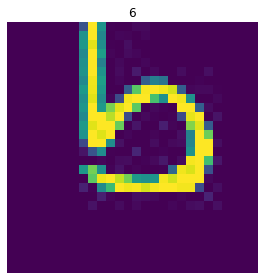

In [5]:
data.show_batch(rows=1)

In [6]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [9]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 14, 14]         3,136      True      
______________________________________________________________________
BatchNorm2d          [64, 14, 14]         128        True      
______________________________________________________________________
ReLU                 [64, 14, 14]         0          False     
______________________________________________________________________
MaxPool2d            [64, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [64, 7, 7]           36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 7, 7]           128        True      
______________________________________________________________________
ReLU                 [64, 7, 7]           0          False     
___________________________________________________

---

The changes I have made since the last notebook are to add a fourth layer, as I thought it was only scaling down to 2x2 (my previous reading of the model architecture lead to a belief it was downscaling twice per layer, it is not). So at this point I want to try training it a little.

The 4 layer architecture does appear to pretty closely match resnet18.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04
Min loss divided by 10: 5.25E-02


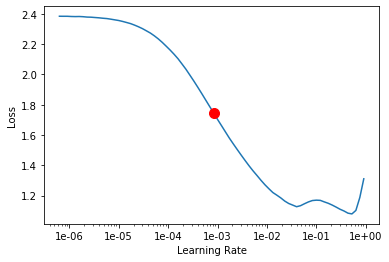

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [10]:
learn.fit_one_cycle(20)

In [11]:
model = resnet().cuda()
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [12]:
learn.fit_one_cycle(100, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

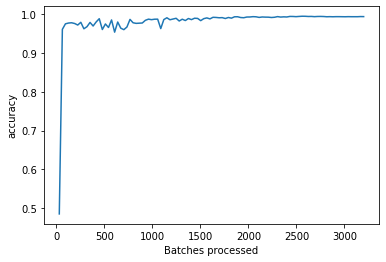

In [174]:
learn.recorder.plot_metrics()

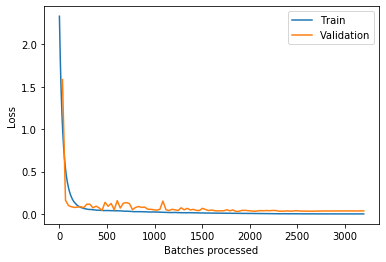

In [175]:
learn.recorder.plot_losses()

---

I've changed the resnet model to remove the initial downsampling and instead add more layers.
This will make it quite a lot bigger.

In [3]:
model = resnet().cuda()

In [9]:
data = load_data(TRAIN_FOLDER, batch_size=1)

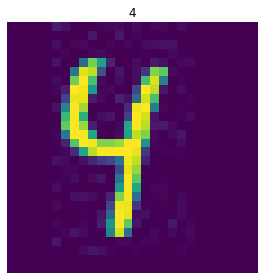

In [10]:
data.show_batch(rows=1)

In [11]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [7]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 28, 28]         3,136      True      
______________________________________________________________________
BatchNorm2d          [64, 28, 28]         128        True      
______________________________________________________________________
ReLU                 [64, 28, 28]         0          False     
______________________________________________________________________
MaxPool2d            [64, 28, 28]         0          False     
______________________________________________________________________
Conv2d               [64, 28, 28]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 28, 28]         128        True      
______________________________________________________________________
ReLU                 [64, 28, 28]         0          False     
___________________________________________________

179m parameters compared to 11m before! It's huge!

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.95 GiB total capacity; 2.88 GiB already allocated; 25.44 MiB free; 14.32 MiB cached)